In [118]:
from differentiable_sorting import diff_sort_weave, bitonic_woven_matrices, smoothmax
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [229]:
np.set_printoptions(suppress=True, precision=2)


## Variance reduction

Because the sorting operation should be invariant to permutations, the error can be reduced very slightly
by running $m$ parallel sorting networks, with each input preceded by a fixed random permutation matrix, and averaging the results. This reduces the error (very) marginally.

```python
        
    def random_permutations(n, m):
        return [np.eye(n)[np.random.permutation(np.arange(n))] for i in range(m)]

    variance_reduced = np.mean([diff_sort(matrices, p @ x) for p in random_permutations(n, m)], axis=0)    
```

In [235]:
np.random.seed(2019)
x = np.random.uniform(-200, 200, 16)
matrices = bitonic_woven_matrices(16)

In [236]:
def random_permutations(n, m):
        return [np.eye(n)[np.random.permutation(np.arange(n))] for i in range(m)]

def variance_reduced(matrices, x, m = 5):
    n = len(x)
    return np.mean([diff_sort_weave(matrices, p @ x) for p in random_permutations(n, m)], axis=0) 

In [237]:
def show_errors(xs, sort_fn):
    truth = np.sort(xs, axis=1)
    sorts = np.stack([sort_fn(x) for x in xs])
    
    plt.imshow(truth-sorts, cmap='RdBu', vmin=-1, vmax=1)
    plt.colorbar()
    plt.axis("off")
    print("RMS error", np.sqrt(np.mean((truth-sorts)**2)))

### Original

RMS error 0.18603505359785322


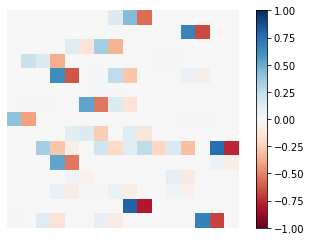

In [238]:
xs = np.random.uniform(-250, 250, (15, 16))
show_errors(xs, lambda x:diff_sort_weave(matrices, x))

### Averaged over 5 permutations

RMS error 0.17893799497429339


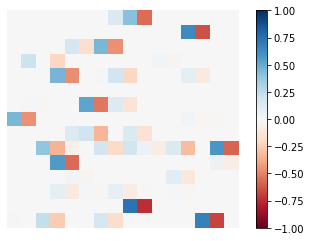

In [244]:
show_errors(xs, lambda x:variance_reduced(matrices, x, m=5))

## Tempering

As well adjustable $\alpha$ parameters in the smoothmax/logsumexp functions, we can also interpolate between sorting and no-sorting, by replacing each permutation matrix $A_i$ with 
$\beta I + (1-\beta A_i)$, for some small $\beta$.

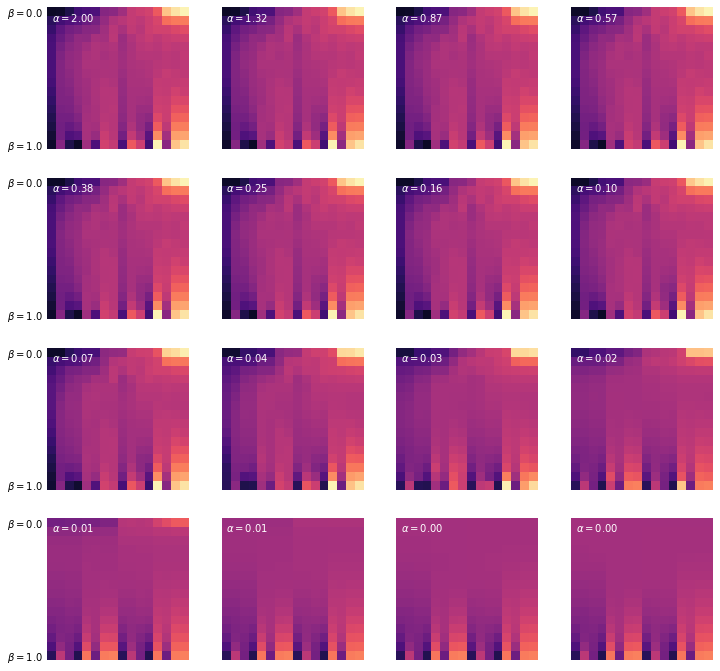

In [259]:
x = np.random.uniform(-250, 250, 16)
matrices = bitonic_woven_matrices(16)

def show_interpolations(matrices, x):
   
    alphas = [2**-alpha-2**-8 for alpha in np.linspace(-1,8,16)]
    sorts =  [[diff_sort_weave(matrices, x, softmax=lambda a,b:smoothmax(a,b,alpha=alpha), 
                                  beta=beta) for beta in np.linspace(0,1,16)] for alpha in alphas]
    
    fig = plt.figure(figsize=(12,12))
    for i,(alpha,alpha_block) in enumerate(zip(alphas, sorts)):
        ax = fig.add_subplot(4,4,i+1)
        ax.imshow(sorts[i], cmap='magma', vmin=-250, vmax=250)
        ax.text(0, 1, f"$\\alpha={alpha:.2f}$", color='white')
        if i%4==0:
            ax.text(-5, 0.5, "$\\beta=0.0$", color='black')
            ax.text(-5, 16-0.5, "$\\beta=1.0$", color='black')

        ax.axis("image")
        ax.axis("off")
show_interpolations(matrices, x)

## Transformations
Any invertible transform can be applied to values before sorting and inverted afterwards. Typically this would be to standardise the variables, and scale the z-scores by a factor of 150 or so:


RMS error 0.6478299931000792


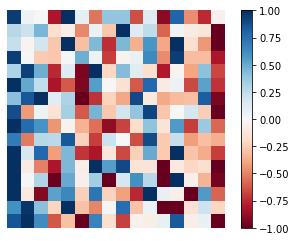

In [227]:
xs = np.random.uniform(-10, 10, (16, 16))
show_errors(xs, lambda x:diff_sort_weave(matrices, x))

RMS error 0.0008208592869724583


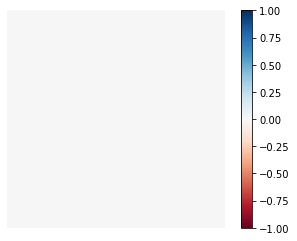

In [228]:
std = (xs - np.mean(xs,axis=1))/ np.std(xs,axis=1)
show_errors(std, lambda x:(diff_sort_weave(matrices, x*150)/150))